---
---
# MODEL TRAINING (RESNET)

### Dartmouth ECoG Lab

### version 1 (2021)
---
---

In [2]:
# libraries
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import os
import copy
import time
import random
import warnings 
import operator
warnings.filterwarnings('ignore')
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchtext import data
from sklearn import metrics
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.externals import joblib
from sklearn.utils import resample 
import splitfolders

# directories
data_dir = './cnn-detectorspect/'
image_dir = './IEDEXPORTS_SPECT/'


# SPLIT DATA

In [367]:
### split exported images into train, test, val dirs (80:10:10)
### note: make sure assigned dir is empty prior to running this! 
# splitfolders.ratio(image_dir, output=data_dir, seed=1031, ratio=(0.7, 0.15, 0.15))
### print number of files in each dir:
path, dirs, files = next(os.walk(data_dir + "train/IED"))
train_ieds = len(files)
print("TRAIN IEDS: %d" %train_ieds)
path2, dirs2, files2 = next(os.walk(data_dir + "train/NONIED"))
train_nonieds = len(files2)
print("TRAIN NONIEDS: %d" %train_nonieds)
path3, dirs3, files3 = next(os.walk(data_dir + "val/IED"))
val_ieds = len(files3)
print("VAL IEDS: %d" %val_ieds)
path4, dirs4, files4 = next(os.walk(data_dir + "val/NONIED"))
val_nonieds = len(files4)
print("VAL NONIEDS: %d" %val_nonieds)

TRAIN IEDS: 688
TRAIN NONIEDS: 1054
VAL IEDS: 147
VAL NONIEDS: 225


# IMAGE PREPROCESSING

Visualization of a few training images:
---------------------------------------


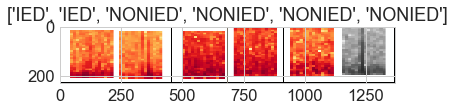

In [369]:
### augment images for resnet: done to prevent overfitting
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), # 224
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Pad(1, fill=0, padding_mode='constant'),
        transforms.RandomGrayscale(p=0.2), # make sure this is always after pad transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # not too important.
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.Pad(1, fill=0, padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=0) ####### batch d:8
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### visualize some training images to understand the data augmentations
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause so that plots are updated

### Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
imshow_num = 6
inputs = inputs[:imshow_num]
classes = classes[:imshow_num]
### Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print("Visualization of a few training images:")
print("---------------------------------------")
imshow(out, title=[class_names[x] for x in classes])
# print(classes)
# print(title)

# MODEL TRAINING

In [370]:
### MODEL ARCHITECTURE:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2) # size of each input sample 
model = model.to(device)
# loss function for model 
criterion = nn.CrossEntropyLoss()
# model optimizer 
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) ### d: 0.001, 1e-4
# decay the learning rate by a factor of 0.1 every 20 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # 5,0.1
# move the input and model to GPU transposeeed if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [374]:
stored_loss = []
stored_acc = []
output = []
predictions = []

def train_model(model,criterion,optimizer,scheduler,num_epochs=20):
    """
    #############################
    # Function for model training
    #############################
    """
    start=time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # each epoch has training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # model.forward(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    output.append(outputs) 
                    predictions.append(preds) 
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            ### store loss and acc
            epoch_loss = running_loss / dataset_sizes[phase]
            stored_loss.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            stored_acc.append(epoch_acc)
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - start
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [375]:
"""
#############
# TRAIN MODEL 
#############
"""

### run model 
model = train_model(model,criterion,optimizer,exp_lr_scheduler, num_epochs = 100) 


Epoch 0/99
----------
train loss: 0.6520 acc: 0.6447
val loss: 0.5916 acc: 0.7608

Epoch 1/99
----------
train loss: 0.3609 acc: 0.8548
val loss: 0.2926 acc: 0.8978

Epoch 2/99
----------
train loss: 0.3349 acc: 0.8691
val loss: 0.6126 acc: 0.7957

Epoch 3/99
----------
train loss: 0.3387 acc: 0.8662
val loss: 0.2781 acc: 0.9032

Epoch 4/99
----------
train loss: 0.3246 acc: 0.8777
val loss: 0.2542 acc: 0.9005

Epoch 5/99
----------
train loss: 0.2902 acc: 0.8915
val loss: 0.3464 acc: 0.8414

Epoch 6/99
----------
train loss: 0.2973 acc: 0.8858
val loss: 1.7341 acc: 0.3952

Epoch 7/99
----------
train loss: 0.2882 acc: 0.8909
val loss: 0.2618 acc: 0.9167

Epoch 8/99
----------
train loss: 0.3030 acc: 0.8783
val loss: 0.2489 acc: 0.9032

Epoch 9/99
----------
train loss: 0.2768 acc: 0.8995
val loss: 0.3860 acc: 0.8414

Epoch 10/99
----------
train loss: 0.2596 acc: 0.8955
val loss: 0.2164 acc: 0.9167

Epoch 11/99
----------
train loss: 0.2694 acc: 0.8921
val loss: 0.5998 acc: 0.7177

Ep

## SAVE MODEL OUTPUTS

In [376]:
### reformat tensors (predictions, outputs) for export
### function to convert CEL values to probabilities for each class:
def probConvert(value): # input single tensor object
    conversion1 = nn.LogSoftmax() # conversion: crossentropyloss -> prob
    val = torch.exp(conversion1(value))
    return val 

### function to reformat outputs from model training:
def celReformat(output, predictions):
    batchpreds = []
    batchoutputs = []
    batchprob0 = []
    batchprob1 = []
    
    for i in range(len(output)):
        batchpreds.append(predictions[i].tolist())
        outp = probConvert(output[i]) # pred prob of 0 (IED), pred prob of 1 (NONIED)
        outp = [item for sublist in outp.tolist() for item in sublist] # flatten to single list: odds = ied prob, evens = nonied prob
        batchprob0.append(outp[::2])
        batchprob1.append(outp[1::2])

    batchpreds = [item for sublist in batchpreds for item in sublist] # flatten list of lists
    batchprob0 = [item for sublist in batchprob0 for item in sublist] # flatten list of lists
    batchprob1 = [item for sublist in batchprob1 for item in sublist] # flatten list of lists

    return (batchpreds, batchprob0, batchprob1)

### run function 
pred, prob0, prob1 = celReformat(output, predictions)

### store outputs
outputdf = pd.DataFrame(
    {'predictions': pred,
     'prob_ied': prob0,
     'prob_nonied': prob1})


In [378]:
### STORE MODEL OUTPUTS; SAVE BEST PERFORMING MODEL:
# store loss (even = training rows, odd = validation rows)
stored_loss = pd.DataFrame(stored_loss)
# store acc (even = training rows, odd = validation rows)
stored_acc = pd.DataFrame(stored_acc)
# export
stored_loss.to_csv(data_dir+'/stored_loss.csv')
stored_acc.to_csv(data_dir+'/stored_acc.csv')
outputdf.to_csv(data_dir+'/stored_outputs.csv')

"""
############
# SAVE MODEL
############
"""
# export model 
torch.save(model, data_dir+'/model_aied18.pt')


# END